### Resizing bounding box

Step by step resizing image and its bounding box.

In [11]:
# import necessary libraries
from PIL import Image
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

During the inference phase, the original image will be resized to match the input specifications of the exported ONNX model. Consequently, it's necessary to adjust the coordinates of the bounding box after prediction to correspond with the original image.

Original image > resize & transform to match the input requirements > output > adjust the coordinates of the bounding box

Original:  (2985, 4478, 3)
After resized:  (298, 447, 3)


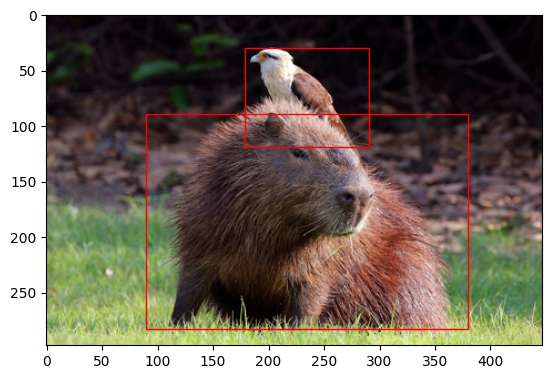

In [12]:
# ia.seed(1)

# select sample
image_path = "image/sample-1.jfif"
image = Image.open(image_path)
image_np = np.array(image)

# original image shape (width, height, channel)
print("Original: ", image_np.shape)

# define the new size (height, width)
new_size = (447, 298)

# resize the image
resized_image = image.resize(new_size, Image.BICUBIC)
# use imgaug to resize the image to keep the image quality
# resized_image = ia.imresize_single_image(image_np, new_size)

print("After resized: ", np.array(resized_image).shape)

# sample bounding boxes
boxes = [
    [89.4000, 89.4000, 379.9500, 283.1000],
    [178.8000, 29.8000, 290.5500, 119.2000]
]

# create a figure and axes
fig, ax = plt.subplots(1)

# display the image
ax.imshow(resized_image)

for box in boxes:
    # create a rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
    # add the patch to the axes
    ax.add_patch(rect)

# show the figure
plt.show()

To resize bounding boxes to fit the original image, need to scale the coordinates of the bounding boxes according to the scale of the original image and the resized image. Here's how to do it.

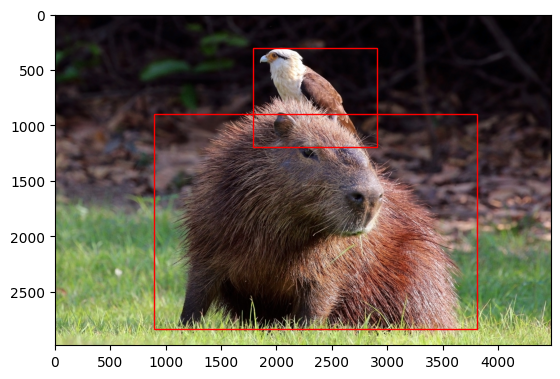

In [13]:
# resize the bounding boxes to fit original image
# get the original image size (height, width)
original_height, original_width = image_np.shape[0], image_np.shape[1]

# convert the resized image to a numpy array and get its size
resized_image_np = np.array(resized_image)
resized_image_height, resized_image_width = resized_image_np.shape[0], resized_image_np.shape[1]

# calculate the scale factors for width and height
width_scale = original_width / resized_image_width 
height_scale = original_height / resized_image_height 

# scale the bounding boxes according to the scale factors
scaled_boxes = []
for box in boxes:
    # each box is a list of coordinates [x1, y1, x2, y2]
    # scale each coordinate using the appropriate scale facto
    scaled_box = [
        box[0] * width_scale, 
        box[1] * height_scale, 
        box[2] * width_scale, 
        box[3] * height_scale
    ]
    # add the scaled box to the list of scaled boxes
    scaled_boxes.append(scaled_box)

# create a figure and axes
fig, ax = plt.subplots(1)

# display the image
ax.imshow(image)

# for each scaled bounding box
for box in scaled_boxes:
    # create a rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
    # add the patch to the axes
    ax.add_patch(rect)

# show the figure
plt.show()

Additionally, can find the relative coordinates of the bounding box, which are expressed as a fraction of the image's width and height. This allows for flexible resizing of the image.

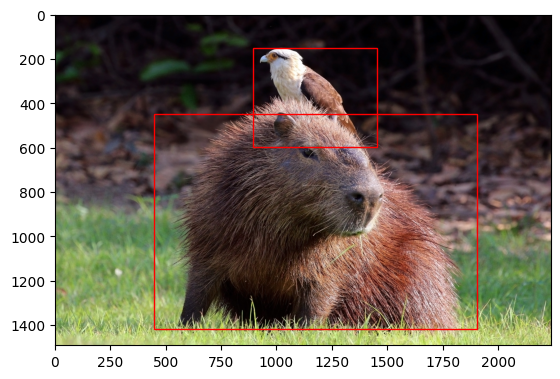

In [14]:
# create a deep copy of the boxes list to avoid modifying the original data
new_boxes = copy.deepcopy(boxes)

# get the relative coordinates of the bounding box
for i in range(len(new_boxes)):
    new_boxes[i][0] /= resized_image_width
    new_boxes[i][1] /= resized_image_height
    new_boxes[i][2] /= resized_image_width
    new_boxes[i][3] /= resized_image_height

# define the new size (height, width)
# convert the absolute coordinates of the bounding boxes to relative coordinates 
# by dividing them by the width and height of the resized image   
half_size = (original_height // 2, original_width // 2)
half_size_height = half_size[0]
half_size_width = half_size[1]

# resize the image to the new size
half_resized_image = ia.imresize_single_image(image_np, half_size)

# resize the bounding boxes to fit the new image size
for box in new_boxes:
    box[0] = box[0] * half_size_width
    box[1] = box[1] * half_size_height
    box[2] = box[2] * half_size_width
    box[3] = box[3] * half_size_height

# create a figure and axes
fig, ax = plt.subplots(1)

# display the image
ax.imshow(half_resized_image)

# draw each bounding box on the image
for box in new_boxes:
    # create a rectangle patch
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
    # add the patch to the axes
    ax.add_patch(rect)

# show the figure
plt.show()

As an alternative, ImgAug, a Python library, offers efficient strategies for managing such situations. For guidance on its usage, please follow this link: https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html